In [1]:
import sys
sys.path.insert(0, "../spectral_approximate_inference")
import numpy as np
import matplotlib.pyplot as plt
from read_mat import ReadMat
import pandas as pd
import time
import cffi
import scipy.io as sio

In [ ]:
ffi = cffi.FFI()
ffi.cdef('float mixing(int n, int k, float *A, float *h, float *V, float eps, int max_iter);'
         'float mixing_plus(int n, int d, int k, float *A, float *h, float *Z, float eps, int max_iter);')

ffi.set_source('_part', r'''
        #include "part.h"
''', sources=['part.c'], source_extension='.c',
   extra_compile_args=['-O3'],
)

ffi.compile(verbose=True)
import _part

<h2> Our method

In [3]:
# Sample n vectors uniformly on unit sphere
def sample_unit_sphere(n, d):
    ret = np.random.normal(0, 1, size=(n, d))
    ret = ret / np.linalg.norm(ret, axis=1, keepdims=True)
    return ret

# Mixing method
def mixing(A, h, V, max_iter=20, eps=1e-2):
    n = A.shape[0]
    k = V.shape[1]
    assert A.shape[1] == n and h.shape[0] == n and h.shape[1] == k
    A = A.astype(np.float32)
    h = h.astype(np.float32)
    _V = V.astype(np.float32)

    diff = _part.lib.mixing(n, k, ffi.from_buffer('float[]', A), ffi.from_buffer('float[]', h), ffi.from_buffer('float[]', _V), eps, max_iter)
    V[:] = _V
    return diff

# Mixing-plus method
def mixing_plus(A, h, Z, k, max_iter=20, eps=1e-2):
    n = A.shape[0]
    d = Z.shape[1]
    m = d // k
    assert A.shape[1] == n and h.shape[0] == n and h.shape[1] == d
    assert d % k == 0
    A = A.astype(np.float32)
    h = h.reshape((n,m,k)).transpose(0,2,1)
    h = np.ascontiguousarray(h, dtype=np.float32)
    _Z = np.ascontiguousarray(Z.reshape((n,m,k)).transpose(0,2,1)).astype(np.float32)

    diff = _part.lib.mixing_plus(n, d, k, ffi.from_buffer('float[]', A), ffi.from_buffer('float[]', h), ffi.from_buffer('float[]', _Z), eps, max_iter)
    Z[:] = _Z.reshape((n,k,m)).transpose(0,2,1).reshape((n,d))
    return diff

def mul_S(s, V):
    d = V.shape[1]
    k = s.shape[0]
    assert d % k == 0
    return (V.reshape(-1, d // k, k) @ s).reshape(V.shape)

# Our method
def compute_mode_sdp(A, h, rounding_iters=10000, method="mixing"):
    n = len(A)
    k = 2
    if method == "mixing":
        d = int(np.ceil(np.sqrt(2*(n+2*(2+1)/2)) + 1))

        V = sample_unit_sphere(n, d)

        # Setting v_t = e_1
        v_t = np.zeros(d)
        v_t[0] = 1

        _h = np.zeros((n, d))
        for i in range(n):
            _h[i, 0] = h[i]

        V = np.asarray(V, order='C')
        A = np.asarray(A, order='C')
        _h = np.asarray(_h, order='C')

        diff = mixing(A, _h, V)
    
    elif method == "mixing-plus":
        d = int(np.ceil(k * np.sqrt(2*n) + 1))

        while(d % k != 0):
            d += 1
        assert d >= k

        C_hat = (k/(k-1))*np.eye(k) - (1/(k-1))*np.full((k, k), 1)
        U, Sigma, Ut = np.linalg.svd(C_hat)
        s = (np.diag(Sigma) ** 0.5) @ Ut

        Z = np.random.normal(0, 1, size=(n, d))
        Z = np.abs(Z)
        Z = Z / np.linalg.norm(Z, axis=1, keepdims=True)

        B = np.zeros((k, d))
        B[np.arange(k), np.arange(k)] = 1

        # Setting v_t = e_1
        v_t = np.zeros(d)
        v_t[0] = 1

        _h = np.zeros((n, d))
        for i in range(n):
            _h[i, 0] = h[i]

        Z = np.asarray(Z, order='C')
        A = np.asarray(A, order='C')
        _h = np.asarray(_h, order='C') 

        diff = mixing_plus(A, _h, Z, k)
        V = mul_S(s.T, Z)
        B = mul_S(s.T, B)

    f_list = []
    t_list = []
    mode = -np.inf
    for _ in range(rounding_iters):
        r = sample_unit_sphere(1, d)
        r = np.reshape(r, -1)
        x = np.sign(V @ r) * np.sign(v_t @ r)
        f = (x.T @ A @ x) / 2 + (h.T @ x)
        t_list.append(time.time())
        f_list.append(f)
    
    return t_list, f_list

<h2> AIS

In [14]:
# p(x) \propto \exp(x^TAx/2 + h^Tx), x \in {-1, 1}^n
def gibbs_sampling(A, h, x, T, num_cycles=10):
    n = len(x)
    for cycle in range(num_cycles):
        for i in range(n):
            p = 1 / (1 + np.exp(- 2 * (A[i, :].T @ x +  h[i]) / T)) # p(x_i=1|x_{-i})
            if np.random.rand() < p:
                x[i] = 1
            else:
                x[i] = -1
    return x

def f_k(x, k, inv_temps, A, h):
    n = len(x)
    weight_on_uniform = (0.5 ** n) ** (1 - inv_temps[k])
    weight_on_true = np.exp((x.T @ A @ x) / 2 + h.T @ x) ** inv_temps[k]
    return weight_on_uniform * weight_on_true

def log_f_k(x, k, inv_temps, A, h):
    n = len(x)
    weight_on_uniform = (inv_temps[k] - 1) * n * np.log(2)
    weight_on_true = inv_temps[k] * ((x.T @ A @ x) / 2 + h.T @ x)
    return weight_on_uniform + weight_on_true

def ais(A, h, num_samples=500, K=100, num_cycles=10):
    n = len(A)
    inv_temps = np.linspace(0, 1, K)
    sm = 0
    log_w_list = []
    mode = -np.inf
    t_list = []
    f_list = []
    for i in range(num_samples):  
        # print(i)
        x = np.random.choice([-1, 1], size=n, replace=True)
        w = 0
        for k in range(1, K):
            w = w + log_f_k(x, k, inv_temps, A, h) - log_f_k(x, k-1, inv_temps, A, h)
            x = gibbs_sampling(A, h, x, 1 / inv_temps[k], num_cycles=num_cycles)
            f = (x.T @ A @ x) / 2 + (h.T @ x)
            t_list.append(time.time())
            f_list.append(f)

    return t_list, f_list

<h2> Complete graph n=20

In [4]:
mat = sio.loadmat('../data/20complete_dataset')
coupling_data = mat['A']
bias_data = mat['h']
ground_truth_modes = np.load("../data/binary_complete_graph_modes.npy")
cw_len = coupling_data.shape[-2]
num_samples = coupling_data.shape[-1]
n = coupling_data.shape[0]
print(cw_len, num_samples, n)

21 100 20


In [5]:
cw = 10
log_scale_range = np.arange(-9, 0, 0.01)

In [7]:
# Run mixing method on all problem instances for mode estimates
major_y_list_sdp = np.zeros(len(log_scale_range))
for sample in range(num_samples):
    A = coupling_data[:, :, cw, sample]
    h = bias_data[:, cw, sample]
    gt = ground_truth_modes[cw, sample]
    
    s_sdp = time.time()
    t_list_sdp, f_list_sdp = compute_mode_sdp(A, h, rounding_iters=500, method="mixing")

    diff_list_sdp = []
    for i in range(len(t_list_sdp)):
        diff_list_sdp.append(t_list_sdp[i] - s_sdp)

    diff_list_sdp = np.log(diff_list_sdp)
    
    # calculate best estimate uptill a tick on x-axis
    # from the estimates
    y_list = []
    for tick in log_scale_range:
        mx = -np.inf
        for i in range(len(diff_list_sdp)):
            if diff_list_sdp[i] <= tick:
                mx = max(mx, f_list_sdp[i])
            else:
                break
        if mx == -np.inf:
            mx = 0
        y_list.append(mx)
    
    y_list = np.array(y_list)
    y_list /= gt
    major_y_list_sdp += y_list
major_y_list_sdp /= num_samples
print(major_y_list_sdp)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.05279347 0.13416356 0.18816788 0.23111102 0.23944129 0.24708568
 0.27333887 0.29299601 0.34404782 0.39652136 0.43587289 0.49574957
 0.54021536 0.57216367 0.59054555 0.60023754 0.61653287 0.65092969
 0.67044828 0.69548607 0.70387627 0.70610219 0.70871524 0.71651768
 0.72416083 0.72521049 0.72961613 0.74157733 0.76366523 0.76478379
 0.76478379 0.77322507 0.77673521 0.78184903 0.79442245 0.80455246
 0.80694384 0.80891212 0.8134788  0.8192481  0.81983776 0.82730905


In [16]:
# Run mixing-plus on all problem instances for mode estimates
major_y_list_sdp_plus = np.zeros(len(log_scale_range))
for sample in range(num_samples):
    A = coupling_data[:, :, cw, sample]
    h = bias_data[:, cw, sample]
    gt = ground_truth_modes[cw, sample]
    
    s_sdp = time.time()
    t_list_sdp, f_list_sdp = compute_mode_sdp(A, h, rounding_iters=500, method="mixing-plus")

    diff_list_sdp = []
    for i in range(len(t_list_sdp)):
        diff_list_sdp.append(t_list_sdp[i] - s_sdp)

    diff_list_sdp = np.log(diff_list_sdp)
    
    # calculate best estimate uptill a tick on x-axis
    # from the estimates
    y_list = []
    for tick in log_scale_range:
        mx = -np.inf
        for i in range(len(diff_list_sdp)):
            if diff_list_sdp[i] <= tick:
                mx = max(mx, f_list_sdp[i])
            else:
                break
        if mx == -np.inf:
            mx = 0
        y_list.append(mx)
    
    y_list = np.array(y_list)
    y_list /= gt
    major_y_list_sdp_plus += y_list
major_y_list_sdp_plus /= num_samples
print(major_y_list_sdp_plus)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

In [ ]:
# Run AIS on all problem instances for mode estimates
K = 25
num_samples_ais = 500
num_cycles = 1

major_y_list_ais = np.zeros(len(log_scale_range))
for sample in range(num_samples):
    print(sample, end="\r")
    A = coupling_data[:, :, cw, sample]
    h = bias_data[:, cw, sample]
    gt = ground_truth_modes[cw, sample]
    
    s_ais = time.time()
    t_list_ais, f_list_ais = ais(A, h, num_samples=num_samples_ais, K=K, num_cycles=num_cycles)

    diff_list_ais = []
    for i in range(len(t_list_ais)):
        diff_list_ais.append(t_list_ais[i] - s_ais)

    diff_list_ais = np.log(diff_list_ais)
    
    y_list = []
    for tick in log_scale_range:
        mx = -np.inf
        for i in range(len(diff_list_ais)):
            if diff_list_ais[i] <= tick:
                mx = max(mx, f_list_ais[i])
            else:
                break
        if mx == -np.inf:
            mx = 0
        y_list.append(mx)
    
    y_list = np.array(y_list)
    y_list /= gt
    major_y_list_ais += y_list
major_y_list_ais /= num_samples
print(major_y_list_ais)

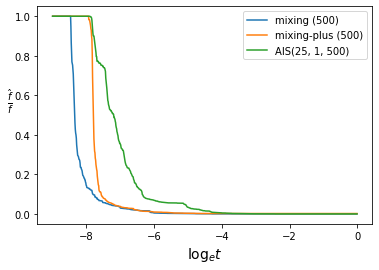

In [19]:
plt.plot(log_scale_range[:], 1-major_y_list_sdp[:], label="mixing (500)")
plt.plot(log_scale_range[:], 1-major_y_list_sdp_plus[:], label="mixing-plus (500)")
plt.plot(log_scale_range[:], 1-major_y_list_ais[:], label="AIS(25, 1, 500)")
# plt.xticks(log_scale_range[:])
plt.xlabel("$\log_e t$", fontsize=14)
plt.ylabel(r'$\frac{\hat{f}}{f}$', fontsize=14, rotation="horizontal")
plt.legend()
plt.show()

<h2> ER graph n=20

In [26]:
mat = sio.loadmat('../data/ER_5_data.mat')
coupling = mat['coupling']
bias = mat['bias']
ground_truth_modes = mat['modes']
print(coupling.shape, bias.shape, ground_truth_modes.shape)

(20, 20, 21, 100) (20, 21, 100) (21, 100)


In [24]:
cw = 10
log_scale_range = np.arange(-9, 0, 0.01)

In [27]:
# Run mixing method on all problem instances for mode estimation
major_y_list_sdp = np.zeros(len(log_scale_range))
for sample in range(num_samples):
    A = coupling[:, :, cw, sample]
    h = bias[:, cw, sample]
    gt = ground_truth_modes[cw, sample]
    
    s_sdp = time.time()
    t_list_sdp, f_list_sdp = compute_mode_sdp(A, h, rounding_iters=500, method="mixing")

    diff_list_sdp = []
    for i in range(len(t_list_sdp)):
        diff_list_sdp.append(t_list_sdp[i] - s_sdp)

    diff_list_sdp = np.log(diff_list_sdp)
    
    y_list = []
    for tick in log_scale_range:
        mx = -np.inf
        for i in range(len(diff_list_sdp)):
            if diff_list_sdp[i] <= tick:
                mx = max(mx, f_list_sdp[i])
            else:
                break
        if mx == -np.inf:
            mx = 0
        y_list.append(mx)
    
    y_list = np.array(y_list)
    y_list /= gt
    major_y_list_sdp += y_list
major_y_list_sdp /= num_samples
print(major_y_list_sdp)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.00952382
 0.01846263 0.03612943 0.04860179 0.08183043 0.1057918  0.13948129
 0.17620295 0.21872165 0.24468359 0.34236954 0.43311931 0.5171174
 0.62965108 0.68910627 0.7236272  0.74084371 0.74955488 0.74959428
 0.75670211 0.76462476 0.77023999 0.77297391 0.77526959 0.7770538
 0.79038142 0.7922263  0.81600855 0.82539939 0.83496587 0.83496587
 0.83759677 0.83759677 0.83811517 0.83811517 0.85070416 0.85081648
 0.85175814 0.8537573  0.86903742 0.87215903 0.88193876 0.882

In [28]:
# Run mixing-plus on all problem instances for mode estimates
major_y_list_sdp_plus = np.zeros(len(log_scale_range))
for sample in range(num_samples):
    A = coupling[:, :, cw, sample]
    h = bias[:, cw, sample]
    gt = ground_truth_modes[cw, sample]
    
    s_sdp = time.time()
    t_list_sdp, f_list_sdp = compute_mode_sdp(A, h, rounding_iters=500, method="mixing-plus")

    diff_list_sdp = []
    for i in range(len(t_list_sdp)):
        diff_list_sdp.append(t_list_sdp[i] - s_sdp)

    diff_list_sdp = np.log(diff_list_sdp)
    
    # calculate best estimate uptill a tick on x-axis
    # from the estimates
    y_list = []
    for tick in log_scale_range:
        mx = -np.inf
        for i in range(len(diff_list_sdp)):
            if diff_list_sdp[i] <= tick:
                mx = max(mx, f_list_sdp[i])
            else:
                break
        if mx == -np.inf:
            mx = 0
        y_list.append(mx)
    
    y_list = np.array(y_list)
    y_list /= gt
    major_y_list_sdp_plus += y_list
major_y_list_sdp_plus /= num_samples
print(major_y_list_sdp_plus)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

In [23]:
# Run AIS on all problem instances for mode estimation
K = 25
num_samples_ais = 500
num_cycles = 1

major_y_list_ais = np.zeros(len(log_scale_range))
for sample in range(num_samples):
    print(sample, end="\r")
    A = coupling_data[:, :, cw, sample]
    h = bias_data[:, cw, sample]
    gt = ground_truth_modes[cw, sample]
    
    s_ais = time.time()
    t_list_ais, f_list_ais = ais(A, h, num_samples=num_samples_ais, K=K, num_cycles=num_cycles)

    diff_list_ais = []
    for i in range(len(t_list_ais)):
        diff_list_ais.append(t_list_ais[i] - s_ais)

    diff_list_ais = np.log(diff_list_ais)
    
    y_list = []
    for tick in log_scale_range:
        mx = -np.inf
        for i in range(len(diff_list_ais)):
            if diff_list_ais[i] <= tick:
                mx = max(mx, f_list_ais[i])
            else:
                break
        if mx == -np.inf:
            mx = 0
        y_list.append(mx)
    
    y_list = np.array(y_list)
    y_list /= gt
    major_y_list_ais += y_list
major_y_list_ais /= num_samples
print(major_y_list_ais)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

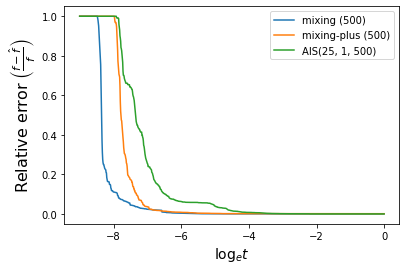

In [32]:
plt.plot(log_scale_range[:], 1-major_y_list_sdp[:], label="mixing (500)")
plt.plot(log_scale_range[:], 1-major_y_list_sdp_plus[:], label="mixing-plus (500)")
plt.plot(log_scale_range[:], 1-major_y_list_ais[:], label="AIS(25, 1, 500)")
# plt.xticks(log_scale_range[:])
plt.xlabel("$\log_e t$", fontsize=14)
plt.ylabel(r'Relative error $\left(\frac{f-\hat{f}}{f}\right)$', fontsize=16, rotation="vertical")
plt.legend()
plt.show()